# [MI-BAY] Estimating error prediction

## List of experiments
* [01 Original experiment](#01-Original-experiment)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [2]:
# Constants
SEED = 42  # Reproducibility

In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
experiments = {}  # Where experiments will be stored

## Utils
Maybe this should go in a library.

In [4]:
def f_gen_data(n_train, f_xy, f_noise, n_test=0, *args, **kwargs):
    """Generate samples and labels for train and test.
    
    PARAMETERS
    ----------
    n_train: int
        Number of train samples to generate.
    f_xy: function()-> ( [feature1, feature2, ...], [target1, target2, etc] )
        Function that generates a tuple of 2 lists, features and targets.
        NOTE: features and targets can be tensors.
    f_noise: function([features]) -> [features]
        Function that adds noise to the features
    n_test: int
        Number of test samples to generate.
        
    RETURN
    ------
    ( ([train features], [train targets]), ([test features], [test targets]) )
    """
    assert(n_test>=0)
    n_samples = n_train + n_test
    x,y = f_xy_lineal(n_samples)
    # Add noise
    noise = f_noise(x)
    y_noise = tuple([y+noise for y, noise in zip(y, noise) ])
    i = np.random.shuffle(np.arange(n_samples))
    return(
        (  # Train data
            [x_feat[:n_train] for x_feat in x],
            [y_labl[:n_train] for y_labl in y_noise]
        ),
        (  # Test data
            [x_feat[n_train:] for x_feat in x],
            [y_labl[n_train:] for y_labl in y_noise]
        )
    )

In [5]:
from tensorflow.python.keras.utils.generic_utils import to_list

def train_step(model, optimizer, f_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = to_list(model(x_train, training=True))
        loss = f_loss(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

## 01 Original experiment

In this experiment we will try to measure the uncertainty the predictions of a machine learning model.
It is framed into our interest for bayesian methods and in particular bayesian deep learning.


The experiment is based on the work of Steve Thorn.
#### References
* Post: [Predicting uncertainty with neural networks](https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d)
* [Original notebook](https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty-variance.ipynb)
* [Local copy of the original notebook](01-Original.ipynb)

In [6]:
# Here I will save the data for the original experiment
experiments['original'] = {}

### Generate the synthetic data

Using a synthetic dataset is useful since we can fully control the data generation phenomenon. This way we can test the potentiality of the method.

Dataset properties:

* $x \in \mathbb{R} \in  [0,1)$ sampled uniformly.
* $y \in \mathbb{R} $

The relationship is $y = 2x+1$

In [7]:
def relationship01(x):
    return 2*x + 1

In [8]:
def f_xy_lineal(n_samples):
    """Generate samples-labels.
    
    RETURN:
     Tuple of tuples (inputs, outputs), 
    """
    x = tf.random.uniform(
        shape=(n_samples,1),
        minval=0.0,
        maxval=1.0
    )
    return(([x],[relationship01(x)]))

#### Adding uncertainty

Since the previous relationship is easily captured by a linear model (i.e. a linear regression), we will add some noise to add uncertainty in the predictions.

The noise is sampled from a [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with a mean of $0$ and a variance of $1$.

That is $\mathcal{N}(\mu=0.0,\sigma^2=1.0)$


##### Heteroscedasticity
The problem with this noise is that is equally distributed along the dataset. So the prediction error will be homogeneus, it fullfils the assumption of [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity) and the uncertainty could also be measured with a simple linear regression.

So in order to make the error ($\varepsilon$) difficult to measure we will make it dependant on the $x$ value in a periodic manner.

$\varepsilon = \sin(4*\pi*x) * 0.4 * \mathcal{N}(0.0,1.0)$

Factors explanation
1. Relative scale based on the $x$ value (this adds the heteroscedasticity). It is also periodic.
1. Absolute scale.
1. Gaussian noise.


##### Considerations
1. Every time we sample from the same $x$, there will be different a different $y$.
1. If we make a histogram with $y$ values sampled from the same $x$ it will be a normal distribution centered on the true value of $x$.
1. The error is periodic, not completely [stochastic](https://en.wikipedia.org/wiki/Stochastic).

In [9]:
def f_noise_gaussian_periodic(samples_x):
    """Generate noise for labels
    
    RETURN: 
     Tuple of tuples (noise for outputs)
    """
    noise = tf.random.normal(
        shape=samples_x[0].shape,
        mean=0.0,
        stddev=1.0
    )* 0.4 * np.sin(samples_x[0]*4*np.pi)
    return([noise])

#### Generate the data

In [10]:
experiments['original']['data'] = {
    'n_train': 10000,
    'n_test': 2000,
    'f_xy': f_xy_lineal,
    'f_noise': f_noise_gaussian_periodic
}

In [11]:
(train_x, train_y), (test_x, test_y) = f_gen_data(**experiments['original']['data'])

#### Visualize the data

The blue dots are training data, and the red dots are testing data, we see they come from the same population.

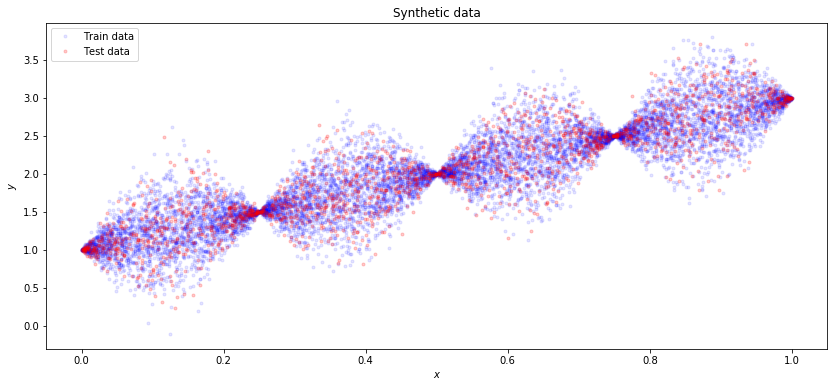

In [12]:
plt.figure(figsize=(14,6))
plt.plot(train_x[0], train_y[0], '.', color='blue', alpha=0.1)
plt.plot(test_x[0], test_y[0], '.', color='red', alpha=0.2)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend([r'Train data','Test data'], loc='upper left', )
plt.title('Synthetic data')
plt.show()

### Model

The candidate model is an [ANN](https://en.wikipedia.org/wiki/Artificial_neural_network), since it can model non-linearities it should be able to fit an error estimation.

There will be 2 outputs.
* y_pred: the prediction $\hat{y}$
* y_var: the prediction error variance $(y-\hat{y})^2$


#### Definition

In [13]:
def get_model01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="x"
    )
    f1 = tf.keras.layers.Dense(
        1000,
        name="hidden",
        activation=tf.keras.activations.relu
    )(in_x)
    out_y = tf.keras.layers.Dense(
        1,
        name="y_pred",
        activation=tf.keras.activations.linear
    )(f1)
    out_var = tf.keras.layers.Dense(
        1,
        name="y_var",
        activation=tf.keras.activations.linear
    )(f1)
    return tf.keras.Model(inputs=[in_x], outputs=[out_y, out_var], name="model01")

In [14]:
experiments['original']['model'] =  get_model01()
experiments['original']['model'].summary()

Model: "model01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 1000)         2000        x[0][0]                          
__________________________________________________________________________________________________
y_pred (Dense)                  (None, 1)            1001        hidden[0][0]                     
__________________________________________________________________________________________________
y_var (Dense)                   (None, 1)            1001        hidden[0][0]                     
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
________________________

**Note**

We have 4002 parameters to fit 10000 data points and the uncertainty in the estimation. Since the relationship is linear $y = ax + b$ (only 2 parameters needed to predict $x$, or y_pred), there are 4000 parameters dedicated to the error prediction, that is a rate of 2 free parameters to 5 data points. Overfitting warning.

#### Loss function

We will use [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function.

In [15]:
def loss01(y_true, y_pred):
    y_pred_sqr_error = (y_true[0]-y_pred[0])**2
    return tf.reduce_mean(
        y_pred_sqr_error +
        (y_pred_sqr_error - y_pred[1])**2 
    )

In [16]:
experiments['original']['loss'] = loss01

In [17]:
# A small test
pred_y = experiments['original']['model'].predict(train_x)
assert(pred_y[0].shape==pred_y[1].shape)
print(pred_y[0].shape)
print(loss01(train_y, pred_y))

(10000, 1)
tf.Tensor(30.65857, shape=(), dtype=float32)


#### Train the model

In [18]:
experiments['original']['hyper'] = {
    'optimizer': tf.keras.optimizers.Adam(
        learning_rate=1e-4,
    ),
    'bs': experiments['original']['data']['n_train'],  # Whole dataset
    'epochs': 10000
}

##### Classic Keras

**NOTE**

If I try...
```python
experiments['original']['model'].fit(
    x=train_x,
    y=train_y,
    batch_size=experiments['original']['hyper']['bs'],
    epochs=experiments['original']['hyper']['epochs'],
)
```

Keras complains the target shape is not as expected.
```
ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor:...
```

`F**k` keras, do the check on the returned value from the loss function!!!! Not on the training data.

##### Au naturel

In [19]:
model=experiments['original']['model']
f_loss=experiments['original']['loss']
optimizer = experiments['original']['hyper']['optimizer']
batch_size  = experiments['original']['hyper']['bs']
epochs = experiments['original']['hyper']['epochs']
x_train = train_x
y_train = train_y

# Function

len_dataset = len(x_train[0])
indices = tf.range(len_dataset) # All indices for the dataset samples

for epoch in range(epochs):
    tf.random.shuffle(indices)
    i_batch = 0
    while i_batch<len_dataset:
        batch_indices = indices[i_batch:i_batch+batch_size]  # Stochastic batch selection
        loss = train_step(
            model,
            optimizer,
            f_loss,
            x_train=[
                tf.gather(params=feat_x, indices=batch_indices)
                for feat_x in x_train
            ],
            y_train=[
                tf.gather(params=feat_y, indices=batch_indices)
                for feat_y in y_train
            ],
        )
        i_batch += batch_size
    if epoch%100==0:
        print("Epoch: {}\tLoss: {}".format(epoch,loss))

Epoch: 0	Loss: 30.6585693359375
Epoch: 100	Loss: 14.94437313079834
Epoch: 200	Loss: 6.7035813331604
Epoch: 300	Loss: 2.891566514968872
Epoch: 400	Loss: 1.454688310623169
Epoch: 500	Loss: 0.9644041061401367
Epoch: 600	Loss: 0.7733063697814941
Epoch: 700	Loss: 0.659925103187561
Epoch: 800	Loss: 0.56321120262146
Epoch: 900	Loss: 0.47060179710388184
Epoch: 1000	Loss: 0.38228508830070496
Epoch: 1100	Loss: 0.30172276496887207
Epoch: 1200	Loss: 0.23313108086585999
Epoch: 1300	Loss: 0.17993855476379395
Epoch: 1400	Loss: 0.1433107852935791
Epoch: 1500	Loss: 0.12136764824390411
Epoch: 1600	Loss: 0.11001031845808029
Epoch: 1700	Loss: 0.10487011820077896
Epoch: 1800	Loss: 0.10276477038860321
Epoch: 1900	Loss: 0.1019301787018776
Epoch: 2000	Loss: 0.10156657546758652
Epoch: 2100	Loss: 0.10136090219020844
Epoch: 2200	Loss: 0.10120358318090439
Epoch: 2300	Loss: 0.10105989128351212
Epoch: 2400	Loss: 0.10091995447874069
Epoch: 2500	Loss: 0.10078167915344238
Epoch: 2600	Loss: 0.10064498335123062
Epoch: 2

KeyboardInterrupt: 

In [20]:
experiments['original']['loss'](
    train_y,
    experiments['original']['model'].predict(train_x)
)

<tf.Tensor: id=464677, shape=(), dtype=float32, numpy=0.09845445>

In [21]:
experiments['original']['loss'](
    test_x,
    experiments['original']['model'].predict(test_x)
)

<tf.Tensor: id=464877, shape=(), dtype=float32, numpy=8.038954>

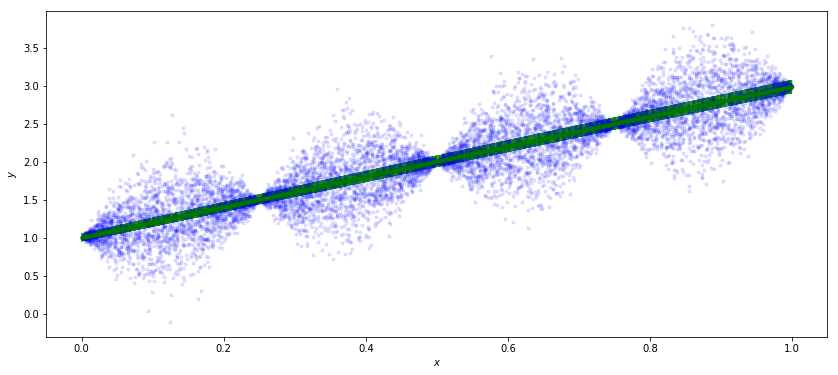

In [22]:
pred_y = experiments['original']['model'].predict(train_x)

plt.figure(figsize=(14,6))
plt.plot(train_x[0], train_y[0], '.', color='blue', alpha=0.1)
#plt.plot(train_x[0], pred_y[0], '.', color='green', alpha=0.1)
plt.errorbar(train_x[0], pred_y[0], yerr=pred_y[1], fmt='.', color='green', alpha=0.1);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

tf.Tensor(0.10492901, shape=(), dtype=float32)


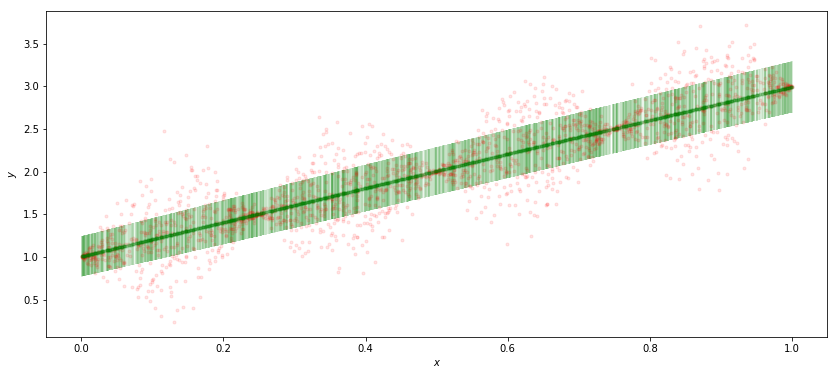

In [23]:
pred_y = experiments['original']['model'].predict(test_x)
print(loss01(test_y, pred_y))

plt.figure(figsize=(14,6))
plt.plot(test_x[0], test_y[0], '.', color='red', alpha=0.1)
plt.errorbar(test_x[0], pred_y[0], yerr=tf.sqrt(pred_y[1]), fmt='.', color='green', alpha=0.1);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

### Train a model to fit 

In [ ]:
x,y = f_xy_lineal(1)


In [ ]:
y

In [ ]:
x